In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#modelos y métricas
# import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree
# preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Creamos una copia del dataset para comenzar a trabajar.

In [ ]:
ds_hotel=pd.read_csv('./hotels_train_filtrado2.csv')
ds_trabajo = ds_hotel.copy()

<ipython-input-5-ca33618eff3f>:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  ds_hotel=pd.read_csv('./hotels_train_filtrado2.csv')


Para la detección de outliers en nuestro dataset, vamos a comenzar realizando un análisis univariado para cada una de sus columnas y decidiremos qué tratamiento darles a aquellos valores atípicos que encontremos.

In [ ]:
ds_trabajo.columns.to_list()

['hotel',
 'lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'deposit_type',
 'customer_type',
 'adr',
 'total_of_special_requests',
 'reservation_status_date',
 'id',
 'is_canceled',
 'arrival_date',
 'region',
 'agent_specified',
 'total_guests',
 'more_than_zero_days_in_waiting_list',
 'season',
 'room_type_match']

En la notebook_1, analizamos las distribuciones de todas estas columnas y ya observamos que algunas de ellas no presentaban valores atípicos:
- `hotel` no presenta valores atípicos. Analizamos anteriormente su distribución mediante un gráfico de torta y observamos que sus dos categorías presentan porcentajes considerables (siendo estos 68% y 32%)
- `season` no presenta valores atípicos. Vimos en un barplot anteriormente que todas las categorías tienen frecuencias considerables
- `is_repeated_guest`, `is_canceled`, `agent_specified`, `more_than_zero_days_in_waiting_list`, `room_type_match` son booleanas y no presentan valores atípicos

En el caso de `lead_time`, habíamos analizado su distribución mediante un boxplot y presentaba outliers.

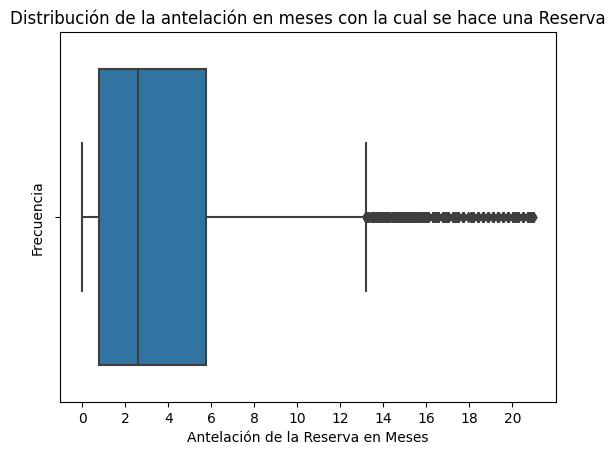

In [ ]:
sns.boxplot(x=ds_trabajo["lead_time"])
plt.xticks(range(0, 22, 2))
plt.xlabel('Antelación de la Reserva en Meses')
plt.ylabel('Frecuencia')
plt.title('Distribución de la antelación en meses con la cual se hace una Reserva')
plt.show()

In [ ]:
#Cuartiles
Q1_lead_time=np.quantile(ds_trabajo.lead_time,0.25)
Q3_lead_time=np.quantile(ds_trabajo.lead_time,0.75)

#Rango intercuartil
IQR_lead_time=Q3_lead_time-Q1_lead_time

#Limite inferior Outliers
out_inf=Q1_lead_time-1.5*IQR_lead_time
out_sup=Q3_lead_time+1.5*IQR_lead_time
print(out_inf)
print(out_sup)

-6.683333333333334
13.183333333333334


Vamos a ver cuántos valores están 1.5 veces por debajo y por encima del IQR para `lead_time`.

In [ ]:
outliers_inf = ds_trabajo[ds_trabajo['lead_time'] < out_inf]
print("Outliers inferiores:",outliers_inf["lead_time"].count())
outliers_sup = ds_trabajo[ds_trabajo['lead_time'] > out_sup]
print("Outliers superiores:",outliers_sup["lead_time"].count())

Outliers inferiores: 0
Outliers superiores: 968


No tenemos negativos en esta columna al tratarse de una cantidad de meses, (ya habíamos hecho este análisis), por lo tanto no tendremos outliers por este lado. En cuanto a los outliers superiores, es una cantidad reducida de registros. Sin embargo, creemos que el tiempo de antelación con el cual se realiza una reserva puede ser un factor importante para determinar una cancelación. Además, en la notebook_1 habíamos hecho un scatter plot de `lead_time` junto con `is_canceled` y notamos que a partir de los 10 meses se cancelaba con mayor frecuencia. Por lo tanto vamos a conservar estos outliers.

En cuanto a `stays_in_weekend_nights` vemos en un boxplot que tenemos algunos valores atípicos.

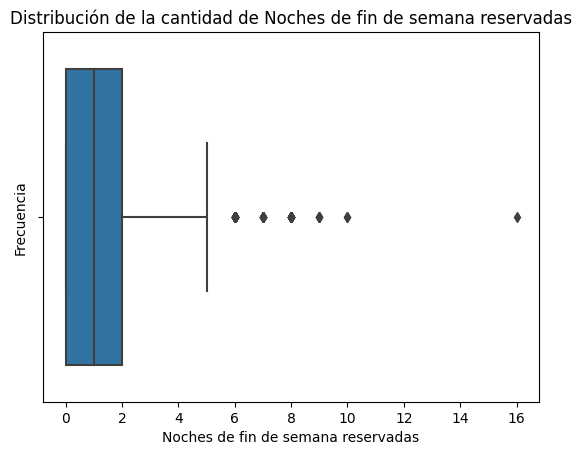

In [ ]:
sns.boxplot(x=ds_trabajo["stays_in_weekend_nights"])
plt.xlabel('Noches de fin de semana reservadas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de Noches de fin de semana reservadas')
plt.show()

In [ ]:
#Cuartiles
Q1_stays_in_weekend_nights=np.quantile(ds_trabajo.stays_in_weekend_nights,0.25)
Q3_stays_in_weekend_nights=np.quantile(ds_trabajo.stays_in_weekend_nights,0.75)

#Rango intercuartil
IQR_stays_in_weekend_nights=Q3_stays_in_weekend_nights-Q1_stays_in_weekend_nights

#Limite inferior Outliers
out_inf=Q1_stays_in_weekend_nights-1.5*IQR_stays_in_weekend_nights
out_sup=Q3_stays_in_weekend_nights+1.5*IQR_stays_in_weekend_nights
print(out_inf)
print(out_sup)

-3.0
5.0


Esta columna tampoco tiene outliers inferiores (es una cantidad), pero sí tiene algunos pocos superiores. Vamos a analizar la relación de aquellos registros con el target `is_canceled`.

In [ ]:
outliers_inf = ds_trabajo[ds_trabajo['stays_in_weekend_nights'] < out_inf]
print("Outliers inferiores:", outliers_inf["stays_in_weekend_nights"].count())

outliers_sup = ds_trabajo[ds_trabajo['stays_in_weekend_nights'] > out_sup]
print("Outliers superiores:", outliers_sup["stays_in_weekend_nights"].count())

Outliers inferiores: 0
Outliers superiores: 98


In [ ]:
ds_trabajo['arrival_date']
# q1 = ds_trabajo['reservation_status_date'].quantile(0.25)
# q3 = ds_trabajo['reservation_status_date'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + (1.5 * iqr)
# lower_bound = q1 - (1.5 * iqr)
# outliers = ds_trabajo[(ds_trabajo['reservation_status_date'] < lower_bound) | (ds_trabajo['reservation_status_date'] > upper_bound)]
# outliers
# # Creación del gráfico
# ax = sns.displot(ds_trabajo['reservation_status_date'], kde=True)
# ax = sns.scatterplot(data=outliers, x='reservation_status_date', y=[0]*len(outliers), color='red', marker='x', s=100)
# ax.set(xlabel='Fecha', title='Distribución de Fechas con Outliers')

# plt.show()


0        2016-09-05
1        2015-10-31
2        2016-10-13
3        2016-12-12
4        2017-03-19
            ...    
43088    2017-02-08
43089    2016-04-09
43090    2016-04-15
43091    2016-08-02
43092           NaN
Name: arrival_date, Length: 43093, dtype: object

Observamos que, si bien son pocos registros, cuando se reservan más de 5 noches de fin de semana hay una tendencia marcada a cancelar la reserva. Por este motivo, vamos a conservar estos outliers.

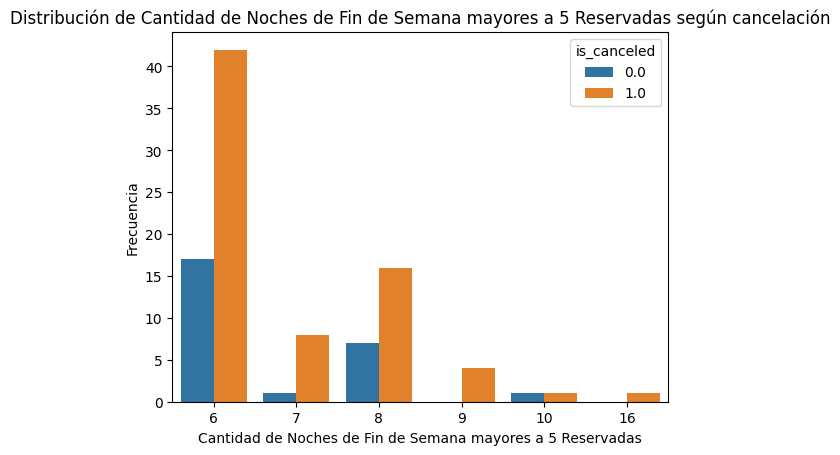

In [ ]:
df = ds_trabajo.loc[ds_trabajo['stays_in_weekend_nights'] > 5]
grafico = sns.countplot(x=df['stays_in_weekend_nights'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de Noches de Fin de Semana mayores a 5 Reservadas')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de Noches de Fin de Semana mayores a 5 Reservadas según cancelación")

plt.show()

En cuanto a `stays_in_week_nights`, sucede algo similar a `stays_in_weekend_nights`. Tenemos algunos valores atípicos superiores.

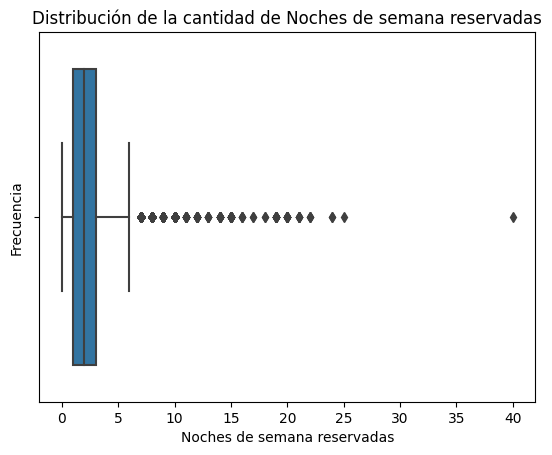

In [ ]:
sns.boxplot(x=ds_trabajo["stays_in_week_nights"])
plt.xlabel('Noches de semana reservadas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de Noches de semana reservadas')
plt.show()

In [ ]:
#Cuartiles
Q1_stays_in_week_nights=np.quantile(ds_trabajo.stays_in_week_nights,0.25)
Q3_stays_in_week_nights=np.quantile(ds_trabajo.stays_in_week_nights,0.75)

#Rango intercuartil
IQR_stays_in_week_nights=Q3_stays_in_week_nights-Q1_stays_in_week_nights

#Limite inferior Outliers
out_inf=Q1_stays_in_week_nights-1.5*IQR_stays_in_week_nights
out_sup=Q3_stays_in_week_nights+1.5*IQR_stays_in_week_nights
print(out_inf)
print(out_sup)

-2.0
6.0


In [ ]:
outliers_inf = ds_trabajo[ds_trabajo['stays_in_week_nights'] < out_inf]
print("Outliers inferiores:", outliers_inf["stays_in_week_nights"].count())

outliers_sup = ds_trabajo[ds_trabajo['stays_in_week_nights'] > out_sup]
print("Outliers superiores:",outliers_sup["stays_in_week_nights"].count())

Outliers inferiores: 0
Outliers superiores: 1203


Si bien son pocos outliers superiores, creemos que hay una variabilidad respecto al target `is_canceled` para estos registros. Por otro lado, creemos que podemos obtener información haciendo un análisis multivariado de `stays_in_week_nights`, `stays_in_weekend_nights` (ambas están correlacionadas) y el target `is_canceled`. TODO

In [ ]:
#Calulo el vector de medias
vmedias=np.mean(ds_trabajo[['stays_in_week_nights','stays_in_weekend_nights']])

#Calculo la diferencia entre las observaciones y el vector de medias
x_dif = ds_trabajo[['stays_in_week_nights','stays_in_weekend_nights']] - vmedias

#Calculo matriz de covarianza y su inversa
cov=ds_trabajo[['stays_in_week_nights','stays_in_weekend_nights']].cov().values
inv_cov = np.linalg.inv(cov)

#Calculamos el cuadrado de la distancia de mahalanobis
mahal =np.dot( np.dot(x_dif, inv_cov) , x_dif.T)

ds_trabajo['mahalanobis']=mahal.diagonal()

In [ ]:
sns.boxplot(y=ds_trabajo.mahalanobis)

Tomamos un umbral de 95.

In [ ]:
umbral=95

#Observaciones anómalas
ds_trabajo[ds_trabajo['mahalanobis']>umbral]

Vemos que hay 46 registros outliers según Mahalanobis. Los vamos a visualizar en un scatter plot.

In [ ]:
#Grafico scatter
es_outlier = (ds_trabajo['mahalanobis'] > umbral)

sns.scatterplot(x=ds_trabajo.stays_in_week_nights,y=ds_trabajo.stays_in_weekend_nights, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma stays_in_week_nights vs stays_in_weekend_nights')
plt.show()

ds_trabajo = ds_trabajo.drop('mahalanobis',axis=1)

Viendo este gráfico observamos nuevamente que ambas variables están correlacionadas. Hay muy pocos outliers a partir de aproximadamente las 20 noches de semana reservadas.  Si bien son outliers porque no tienen una distribución similar a la regular, la tendencia es la misma: entre más noches de semana se reservan, más noches de fin de semana, lo cual parece lógico.
Veremos su relación con el target.

In [ ]:
#Calulo el vector de medias
vmedias=np.mean(ds_trabajo[['stays_in_week_nights','stays_in_weekend_nights','is_canceled']])

#Calculo la diferencia entre las observaciones y el vector de medias
x_dif = ds_trabajo[['stays_in_week_nights','stays_in_weekend_nights','is_canceled']] - vmedias

#Calculo matriz de covarianza y su inversa
cov=ds_trabajo[['stays_in_week_nights','stays_in_weekend_nights','is_canceled']].cov().values
inv_cov = np.linalg.inv(cov)

#Calculamos el cuadrado de la distancia de mahalanobis
mahal =np.dot( np.dot(x_dif, inv_cov) , x_dif.T)

ds_trabajo['mahalanobis_2']=mahal.diagonal()

In [ ]:
# #Ordeno las distancias de menor a mayor
np.sort(ds_trabajo.mahalanobis_2)

In [ ]:

#Observacione anómalas
ds_trabajo[ds_trabajo['mahalanobis_2']>umbral]

In [ ]:
#Gráfico 3D
es_outlier = (ds_trabajo['mahalanobis_2'] > umbral)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

color=[f"C{n}" for n in (es_outlier*1)]
ax.scatter(ds_trabajo.stays_in_week_nights,ds_trabajo.stays_in_weekend_nights,ds_trabajo.is_canceled,c=color)
ax.set_xlabel('stays_in_week_nights')
ax.set_ylabel('stays_in_weekend_nights')
ax.set_zlabel('is_canceled')
plt.title('Dispersograma de Noches de Semana y Noches de Fin de Semana según cancelación de la reserva')
plt.show()

ds_trabajo = ds_trabajo.drop('mahalanobis_2',axis=1)

La distribución de estos outliers es muy pareja, lo que indica que no hay valores extremos que influyan significativamente en la relación entre ellas.

In [ ]:
ds_trabajo.loc[es_outlier, 'stays_in_weekend_nights'] = ds_trabajo['stays_in_weekend_nights'].mean()
ds_trabajo.loc[es_outlier, 'stays_in_week_nights'] = ds_trabajo['stays_in_week_nights'].mean()

Para `previous_cancellations`, tenemos outliers superiores. En la notebook_1 habíamos analizado que la distribución de la variable respecto de `is_canceled` era muy variada, por lo tanto vamos a hacer un análisis más profundo de estos outliers para tomar una decisión.

In [ ]:
sns.boxplot(x=ds_trabajo["previous_cancellations"])
plt.xlabel('Cancelaciones previas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de Cancelaciones previas')
plt.show()

In [ ]:
#Cuartiles
Q1_previous_cancellations=np.quantile(ds_trabajo.previous_cancellations,0.25)
Q3_previous_cancellations=np.quantile(ds_trabajo.previous_cancellations,0.75)

#Rango intercuartil
IQR_previous_cancellations=Q3_previous_cancellations-Q1_previous_cancellations

#Limite inferior Outliers
out_inf=Q1_previous_cancellations-1.5*IQR_previous_cancellations
out_sup=Q3_previous_cancellations+1.5*IQR_previous_cancellations
print(out_inf)
print(out_sup)

In [ ]:
outliers_inf = ds_trabajo[ds_trabajo['previous_cancellations'] < out_inf]
print("Outliers inferiores:", outliers_inf["previous_cancellations"].count())

outliers_sup = ds_trabajo[ds_trabajo['previous_cancellations'] > out_sup]
print("Outliers superiores:",outliers_sup["previous_cancellations"].count())

Observamos esta variabilidad respecto de `is_canceled` separando las cantidades en dos barplots para mejorar la legibilidad. La cantidad de cancelaciones previas podría estar relacionada a la antelación con la cual se hace una reserva. Creemos que será útil hacer un análisis multivariado de `previous_cancellations`, `lead_time` y el target `is_canceled`.

Vamos a analizar si hay outliers multivariados entre previous_cancellations y lead_time.

In [ ]:
#Scatter Plot
plt.scatter(ds_trabajo.previous_cancellations,ds_trabajo.lead_time)
plt.title('Dispersograma previous_cancellations vs lead_time')
plt.xlabel('previous_cancellations')
plt.ylabel('lead_time')
plt.show()

In [ ]:
#Calulo el vector de medias
vmedias=np.mean(ds_trabajo[['previous_cancellations','lead_time']])

#Calculo la diferencia entre las observaciones y el vector de medias
x_dif = ds_trabajo[['previous_cancellations','lead_time']] - vmedias

#Calculo matriz de covarianza y su inversa
cov=ds_trabajo[['previous_cancellations','lead_time']].cov().values
inv_cov = np.linalg.inv(cov)

#Calculamos el cuadrado de la distancia de mahalanobis
mahal =np.dot( np.dot(x_dif, inv_cov) , x_dif.T)

ds_trabajo['mahalanobis']=mahal.diagonal()

In [ ]:
sns.boxplot(y=ds_trabajo.mahalanobis)

Vamos a definir un umbral de atípicos en 50.

In [ ]:
umbral=50

#Observaciones anómalas
ds_trabajo[ds_trabajo['mahalanobis']>umbral]

Vemos que hay 125 registros outliers según Mahalanobis. Los vamos a visualizar en un scatter plot.

In [ ]:
#Grafico scatter
es_outlier = (ds_trabajo['mahalanobis'] > umbral)

sns.scatterplot(x=ds_trabajo.previous_cancellations,y=ds_trabajo.lead_time, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma previous_cancellations vs lead_time')
plt.show()

ds_trabajo = ds_trabajo.drop('mahalanobis',axis=1)

Vemos que estos pocos outliers están comprendidos entre las 10 y poco más de 25 cancelaciones previas. Y también observamos que estos se distribuyen entre los 0 y 10 meses de antelación. Creemos que es anormal que una persona tenga tantas cancelaciones previas, lo que nos hace pensar que pueden ser errores de carga. Vamos a analizar el comportamiento respecto de `is_canceled`.

In [ ]:
#Calulo el vector de medias
vmedias=np.mean(ds_trabajo[['previous_cancellations','lead_time','is_canceled']])

#Calculo la diferencia entre las observaciones y el vector de medias
x_dif = ds_trabajo[['previous_cancellations','lead_time','is_canceled']] - vmedias

#Calculo matriz de covarianza y su inversa
cov=ds_trabajo[['previous_cancellations','lead_time','is_canceled']].cov().values
inv_cov = np.linalg.inv(cov)

#Calculamos el cuadrado de la distancia de mahalanobis
mahal =np.dot( np.dot(x_dif, inv_cov) , x_dif.T)

ds_trabajo['mahalanobis_2']=mahal.diagonal()

In [ ]:
# #Ordeno las distancias de menor a mayor
np.sort(ds_trabajo.mahalanobis_2)

In [ ]:
umbral=50

#Observacione anómalas
ds_trabajo[ds_trabajo['mahalanobis_2']>umbral]

Parece que hay una relación compleja entre las tres variables. En particular, parece haber un patrón en el que hay una cantidad similar de cancelaciones previas en un rango específico de tiempo, pero las cancelaciones no están relacionadas con la antelación de la reserva. Por otro lado, hay una tendencia a cancelar después de un cierto número de cancelaciones previas, independientemente de la antelación de la reserva. Una de nuestras hipótesis, como dijimos, es que estos outliers pueden tratarse de un error en la carga de los datos.

Debido a lo poco probable que es que alguien cancele tantas veces una reserva, vamos a considerar estos valores como errores de carga. Vamos a corregirlos con la media.

In [ ]:
media_columna = ds_trabajo.loc[es_outlier, 'previous_cancellations'].mean()
ds_trabajo.loc[es_outlier, 'previous_cancellations'] = media_columna

In [ ]:
ds_trabajo = ds_trabajo.drop('mahalanobis_2', axis=1)

In [ ]:
df = ds_trabajo.loc[ds_trabajo['stays_in_week_nights'] > 8]
grafico = sns.countplot(x=df['stays_in_week_nights'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de Noches de Semana mayores a 8 Reservadas')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de Noches de Semana mayores a 8 Reservadas según cancelación")

plt.show()

Para `previous_cancellations`, tenemos outliers superiores. En la notebook_1 habíamos analizado que la distribución de la variable respecto de `is_canceled` era muy variada, por lo tanto vamos a hacer un análisis más profundo de estos outliers para tomar una decisión.

In [ ]:
sns.boxplot(x=ds_trabajo["previous_cancellations"])
plt.xlabel('Cancelaciones previas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de Cancelaciones previas')
plt.show()

In [ ]:
#Cuartiles
Q1_previous_cancellations=np.quantile(ds_trabajo.previous_cancellations,0.25)
Q3_previous_cancellations=np.quantile(ds_trabajo.previous_cancellations,0.75)

#Rango intercuartil
IQR_previous_cancellations=Q3_previous_cancellations-Q1_previous_cancellations

#Limite inferior Outliers
out_inf=Q1_previous_cancellations-1.5*IQR_previous_cancellations
out_sup=Q3_previous_cancellations+1.5*IQR_previous_cancellations
print(out_inf)
print(out_sup)

In [ ]:
outliers_inf = ds_trabajo[ds_trabajo['previous_cancellations'] < out_inf]
print("Outliers inferiores:", outliers_inf["previous_cancellations"].count())

outliers_sup = ds_trabajo[ds_trabajo['previous_cancellations'] > out_sup]
print("Outliers superiores:",outliers_sup["previous_cancellations"].count())

Observamos esta variabilidad respecto de `is_canceled` separando las cantidades en dos barplots para mejorar la legibilidad. La cantidad de cancelaciones previas podría estar relacionada a la antelación con la cual se hace una reserva. Creemos que será útil hacer un análisis multivariado de `previous_cancellations`, `lead_time` y el target `is_canceled`. TODO

In [ ]:
df = ds_trabajo.loc[ds_trabajo['previous_cancellations'] <= 1]
grafico = sns.countplot(x=df['previous_cancellations'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de cancelaciones de reservas previas (menores a 1)')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de cancelaciones de reservas previas (menores a 1) según cancelación")

plt.show()

In [ ]:
df = ds_trabajo.loc[ds_trabajo['previous_cancellations'] > 1]
grafico = sns.countplot(x=df['previous_cancellations'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de cancelaciones de reservas previas (mayores a 1)')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de cancelaciones de reservas previas (mayores a 1) según cancelación")

plt.show()

En cuanto a la variable `previous_bookings_not_canceled`, habíamos visto en la notebook_1 que tiene un comportamiento inverso a `previous_cancellations`: entre más reservas no canceladas, menor posibilidad de cancelación.

In [ ]:
sns.boxplot(x=ds_trabajo["previous_bookings_not_canceled"])
plt.xlabel('Reservas previas no canceladas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de reservas previas no canceladas')
plt.show()

In [ ]:
#Cuartiles
Q1_previous_bookings_not_canceled=np.quantile(ds_trabajo.previous_bookings_not_canceled,0.25)
Q3_previous_bookings_not_canceled=np.quantile(ds_trabajo.previous_bookings_not_canceled,0.75)

#Rango intercuartil
IQR_previous_bookings_not_canceled=Q3_previous_bookings_not_canceled-Q1_previous_bookings_not_canceled

#Limite inferior Outliers
out_inf=Q1_previous_bookings_not_canceled-1.5*IQR_previous_bookings_not_canceled
out_sup=Q3_previous_bookings_not_canceled+1.5*IQR_previous_bookings_not_canceled
print(out_inf)
print(out_sup)

In [ ]:
outliers_inf = ds_trabajo[ds_trabajo['previous_bookings_not_canceled'] < out_inf]
print("Outliers inferiores:", outliers_inf["previous_bookings_not_canceled"].count())

outliers_sup = ds_trabajo[ds_trabajo['previous_bookings_not_canceled'] > out_sup]
print("Outliers superiores:",outliers_sup["previous_bookings_not_canceled"].count())

Hay pocos outliers. TODO: sumarla al analisis multivariado anterior.

Para `booking_changes`, observamos una cantidad más considerable de outliers superiores.

In [ ]:
sns.boxplot(x=ds_trabajo["booking_changes"])
plt.xlabel('Cantidad de cambios en la reserva')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de cambios en la reserva')
plt.show()

In [ ]:
#z-score modificado
mediana_booking_changes=np.median(ds_trabajo.booking_changes)
MAD=np.median(np.absolute(ds_trabajo.booking_changes-mediana_booking_changes))

ds_trabajo['zm_booking_changes']=(ds_trabajo.booking_changes - mediana_booking_changes)*0.6745/MAD

zm_booking_changes_inf = ds_trabajo[ds_trabajo['zm_booking_changes'] < 3.5]
print("Cantidad de registros con z-score menor a 3.5:", zm_booking_changes_inf["zm_booking_changes"].count())

zm_booking_changes_sup = ds_trabajo[ds_trabajo['zm_booking_changes'] > 3.5]
print("Cantidad de registros con z-score mayor a 3.5:", zm_booking_changes_sup["zm_booking_changes"].count())

# eliminamos la columna zm
ds_trabajo = ds_trabajo.drop('zm_booking_changes', axis=1)

Sin embargo, notamos que en todos los casos se cancela menos de lo que no. Creemos que esta columna podría no estar aportando información. Vamos a hacer un análisis multivariado. TODO

In [ ]:
# df = ds_trabajo.loc[ds_trabajo['booking_changes'] > 0]
# grafico = sns.countplot(x=df['booking_changes'], hue='is_canceled', data=ds_trabajo)

# plt.xlabel('Cantidad de cambios en la reserva')
# plt.ylabel('Frecuencia')
# plt.title("Distribución de Cantidad de cambios en la reserva según cancelación")

# plt.show()

In [ ]:
# from sklearn.neighbors import LocalOutlierFactor

# sns.scatterplot(x=ds_trabajo['booking_changes'],y=ds_trabajo['previous_bookings_not_canceled'],hue=ds_trabajo['is_canceled'])
# plt.title('Diagrama de Dispersión booking_changes vs previous_bookings_not_canceled')
# plt.show()

In [ ]:
# #Conjunto de entrenamiento
# X=ds_trabajo[['booking_changes','lead_time']].values

# #Creo el clasificador
# clf = LocalOutlierFactor(n_neighbors=20)

# #Genero prediccion
# y_pred = clf.fit_predict(X)

# #Guardo los scores
# ds_trabajo['scores']=clf.negative_outlier_factor_

In [ ]:
# #Calculo radio para plotear score
# radius = (ds_trabajo.scores.max() - ds_trabajo.scores) / (ds_trabajo.scores.max() - ds_trabajo.scores.min())

# #Grafico LOF
# plt.figure(figsize=(10,10))
# plt.title("Local Outlier Factor (LOF)")
# plt.scatter(ds_trabajo.booking_changes.values,ds_trabajo.lead_time.values, edgecolor='grey', s=30, label='datos',facecolors='none')
# plt.scatter(ds_trabajo.booking_changes.values,ds_trabajo.lead_time.values, s=1300 * radius, edgecolors='red',facecolors='none', label='Outlier scores')
# legend = plt.legend(loc='upper left')
# legend.legendHandles[0]._sizes = [10]
# legend.legendHandles[1]._sizes = [20]
# plt.show()

Para `adr`

In [ ]:
sns.boxplot(x=ds_trabajo["adr"])
plt.xlabel('Tarifa diaria promedio')
plt.ylabel('Frecuencia')
plt.title('Distribución de la tarifa diaria promedio')
plt.show()

In [ ]:
#Cuartiles
Q1_adr =np.quantile(ds_trabajo.adr,0.25)
Q3_adr =np.quantile(ds_trabajo.adr,0.75)
IQR_adr=Q3_adr-Q1_adr
out_inf=Q1_adr-1.5*IQR_adr
out_sup=Q3_adr+1.5*IQR_adr
print(out_inf)
print(out_sup)
print(IQR_adr)
outliers_inf = ds_trabajo[ds_trabajo['adr'] < out_inf]
print("Outliers inferiores:", outliers_inf["adr"].count())
outliers_sup = ds_trabajo[ds_trabajo['adr'] > out_sup]
print("Outliers superiores:",outliers_sup["adr"].count())

In [ ]:

ds_trabajo['adr_group'] = (ds_trabajo['adr'] // 10) * 10
df = ds_trabajo.groupby('adr_group').filter(lambda x: len(x) > out_sup)
grafico = sns.countplot(x=df['adr_group'], hue='is_canceled', data=ds_trabajo, palette='muted')
plt.xlabel('Valor de adr (agrupado)')
plt.ylabel('Frecuencia')
plt.title("Distribución de adr respecto a is_canceled")
plt.show()

Podemos ver que apartir de los valores de adr con una media de 80 son muy aceptados, al haber poca taza de cancelados y que apartir de los mismos, el adr aumenta y su taza de cancelados se equipara."

Para `total_of_special_requests`

In [ ]:
sns.boxplot(x=ds_trabajo["total_of_special_requests"])
plt.xlabel('Cantidad de solicitudes especiales')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Cantidad de solicitudes especiales')
plt.show()

In [ ]:
#Cuartiles
Q1_total_of_special_requests =np.quantile(ds_trabajo.total_of_special_requests,0.25)
Q3_total_of_special_requests =np.quantile(ds_trabajo.total_of_special_requests,0.75)
IQR_total_of_special_requests=Q3_total_of_special_requests-Q1_total_of_special_requests
out_inf=Q1_total_of_special_requests-1.5*IQR_total_of_special_requests
out_sup=Q3_total_of_special_requests+1.5*IQR_total_of_special_requests
print(out_inf)
print(out_sup)
print(IQR_total_of_special_requests)
outliers_inf = ds_trabajo[ds_trabajo['total_of_special_requests'] < out_inf]
print("Outliers inferiores:", outliers_inf["total_of_special_requests"].count())
outliers_sup = ds_trabajo[ds_trabajo['total_of_special_requests'] > out_sup]
print("Outliers superiores:",outliers_sup["total_of_special_requests"].count())

Para `total_guests`

In [ ]:
sns.boxplot(x=ds_trabajo["total_guests"])
plt.xlabel('Cantidad de huespedes')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Cantidad de huespedes')
plt.show()

In [ ]:
#z-score modificado
mediana_total_guests=np.median(ds_trabajo.total_guests)
MAD=np.median(np.absolute(ds_trabajo.total_guests-mediana_total_guests))

ds_trabajo['zm_total_guests']=(ds_trabajo.total_guests - mediana_total_guests)*0.6745/MAD

zm_total_guests_inf = ds_trabajo[ds_trabajo['zm_total_guests'] < 3.5]
print("Cantidad de registros con z-score menor a 3.5:", zm_total_guests_inf["zm_total_guests"].count())

zm_total_guests = ds_trabajo[ds_trabajo['zm_total_guests'] > 3.5]
print("Cantidad de registros con z-score mayor a 3.5:", zm_total_guests["zm_total_guests"].count())

ds_trabajo = ds_trabajo.drop('zm_total_guests', axis=1)

Vamos a analizar si hay outliers multivariados entre total_guests y total_of_special_requests.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

sns.scatterplot(x=ds_trabajo['total_guests'],y=ds_trabajo['total_of_special_requests'],hue=ds_trabajo['is_canceled'])
plt.title('Dispersograma total_guests vs total_of_special_requests')
plt.show()

In [ ]:
 #Conjunto de entrenamiento
x=ds_trabajo[['total_guests','total_of_special_requests']].values

#Creo el clasificador
clasif = LocalOutlierFactor(n_neighbors=20)

#Genero prediccion
y_pred = clasif.fit_predict(x)

#Guardo los scores
ds_trabajo['score']=clasif.negative_outlier_factor_

In [ ]:
#Calculo radio para plotear score
radio = (ds_trabajo.score.max() - ds_trabajo.score) / (ds_trabajo.score.max() - ds_trabajo.score.min())

#Grafico LOF
plt.figure(figsize=(10,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(ds_trabajo.booking_changes.values,ds_trabajo.lead_time.values, edgecolor='grey', s=30, label='datos',facecolors='none')
plt.scatter(ds_trabajo.total_guests.values,ds_trabajo.total_of_special_requests.values, s=1300 * radio, edgecolors='red',facecolors='none', label='Outlier scores')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

""Analisis del grafico de arriba


Para `market_segment`, notamos que hay algunas categorías con muy pocas frecuencias. Tomaremos un umbral de 3k registros (menos del 5% del total de datos) como categorías consideradas de baja frecuencia para unificarlas en una categoría `others`. Por otro lado, eliminaremos las undefined.

In [ ]:
frecuencia = ds_trabajo['market_segment'].value_counts()
print(frecuencia)
plt.xlabel('Segmento de Mercado')
plt.ylabel('Frecuencia')
plt.title('Distribución del Segmento de Mercado')
frecuencia.plot(kind='bar')
plt.show()

In [ ]:
ds_trabajo['market_segment'] = ds_trabajo['market_segment'].replace(['Corporate', 'Complementary', 'Aviation'], 'Others')

In [ ]:
frecuencia = ds_trabajo['market_segment'].value_counts()
print(frecuencia)
plt.xlabel('Segmento de Mercado')
plt.ylabel('Frecuencia')
plt.title('Distribución del Segmento de Mercado')
frecuencia.plot(kind='bar')
plt.show()

Para `deposit_type`, vemos que tenemos sólo dos categorías. No hay outliers, las conservamos tal como estan.

In [ ]:
frecuencia = ds_trabajo['deposit_type'].value_counts()
print(frecuencia)

plt.xlabel('Tipo de depósito')
plt.ylabel('Frecuencia')
plt.title('Distribución del Tipo de depósito')
frecuencia.plot(kind='bar')
plt.show()

Para `customer_type`, vemos que la mayor parte de los valores los concentra `Transient`, sin embargo decidimos dejar las 3 categorías ya que creemos que el tipo de cliente que hizo la reserva puede influir en la decisión de cancelación.

In [ ]:
frecuencia = ds_trabajo['customer_type'].value_counts()
print(frecuencia)

plt.xlabel('Tipo de cliente')
plt.ylabel('Frecuencia')
plt.title('Distribución del Tipo de cliente')
frecuencia.plot(kind='bar')
plt.show()

Tras el análisis de outliers, haremos unos pequeños cambios más para pulir el dataset. Vamos a eliminar las columnas Undefined que vimos anteriormente.

In [ ]:
ds_trabajo = ds_trabajo.drop(ds_trabajo[ds_trabajo['distribution_channel'] == 'Undefined'].index)
ds_trabajo = ds_trabajo.drop(ds_trabajo[ds_trabajo['market_segment'] == 'Undefined'].index)

Vamos a pasar las fechas al formato adecuado para trabajarlas en la predicción.

In [ ]:
ds_trabajo['reservation_status_date'] = pd.to_datetime(ds_trabajo.reservation_status_date)
ds_trabajo.reservation_status_date = ds_trabajo.reservation_status_date.apply(lambda x: x.timestamp())
ds_trabajo['arrival_date'] = pd.to_datetime(ds_trabajo.arrival_date)
ds_trabajo.arrival_date = ds_trabajo.arrival_date.apply(lambda x: x.timestamp())



Eliminaremos la columna `reservation_status_date` ya que filtra información para la predicción del target.

In [ ]:
ds_trabajo = ds_trabajo.drop("reservation_status_date",axis=1)
# ds_trabajo = ds_trabajo.drop("adr_group",axis=1)
ds_trabajo = ds_trabajo.drop("id",axis=1)

Vamos a realizar one hot enconding en las columnas categóricas para poder entrenar nuestro modelo.

In [ ]:
# One hot encoding para variables categoricas
ds_trabajo = pd.get_dummies(ds_trabajo, columns=['hotel',
                                                 'market_segment',
                                                 'distribution_channel',
                                                 'is_repeated_guest',
                                                 'deposit_type',
                                                 'customer_type',
                                                 'agent_specified',
                                                 'more_than_zero_days_in_waiting_list',
                                                 'season',
                                                 'region',
                                                 'room_type_match'], drop_first=True)
ds_trabajo.head()


Separamos el dataset de entrenamiento usando una proporción de 70%-30% y estratificando las columnas.

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x=ds_trabajo.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_trabajo_y = ds_trabajo['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

Vemos las proporciones de cancelado / no cancelado para revisar que estas categorías esten bien distirbuidas.

In [ ]:
num_cancelados = sum(y_train)
num_no_cancelados = len(y_train) - num_cancelados
prop_cancelados = num_cancelados / len(y_train)

print("Número de cancelaciones:", num_cancelados)
print("Número de no cancelaciones:", num_no_cancelados)
print("Proporción de cancelaciones:", prop_cancelados)


Vamos a hacer un primer árbol de decisión simple, especificando una profundidad de 20, con criterio de entropía y con 10 como mínimo número de muestras por hoja.

In [ ]:
#Creamos un clasificador con hiperparámetros 
tree_model = tree.DecisionTreeClassifier(criterion="entropy",
                                         max_depth = 20, 
                                         min_samples_leaf=10,
                                         random_state=2) 
#Entrenamos el modelo
model = tree_model.fit(X = x_train, y = y_train)

Realizamos una primera predicción sobre el set de test con este árbol.

In [ ]:
y_pred = model.predict(x_test)
#Valores Predichos
y_pred

Visualizamos su matriz de confusión.

In [ ]:
tabla=confusion_matrix(y_test, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.title("Matriz de confusión de valores predichos por el modelo vs valores reales")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

Vamos a analizar sus métricas.

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Podemos ver que el modelo tiene una precisión del 80.2% y un recall de 79.4% aproximadamente. Por otro lado, el f1 score indica que el modelo está prediciendo correctamente el 80% de las observaciones positivas en el conjunto de datos, al mismo tiempo que mantiene un bajo número de falsos positivos. En el caso de predecir si una reserva será cancelada o no, creemos que una alta precisión es importante, ya que puede ser costoso y perjudicial para el negocio si se cancelan reservas que en realidad no lo necesitaban. Creemos entonces que es importante reducir la cantidad de falsos positivos, es decir, predecir que una reserva se cancelará cuando en realidad no lo hará. Por lo tanto, elegimos optimizar la métrica de precisión para reducir la cantidad de reservas que se cancelan innecesariamente.

Vamos a buscar hiperparámetros por medio de Grid Search, optimizando la métrica de precisión. En esta iteración, vamos a buscar los mejores hiperparámetros con profundidades de 10, 20, 30 y 40, una cantidad mínima de muestras por hoja de 5, 10 y 15 y algunos valores para la poda. Probaremos esto con 5 folds y con el criterio de Gini.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
params = {'max_depth': [10, 20, 30, 40],
          'min_samples_leaf': [5, 10, 15],
          'ccp_alpha': [0.0, 0.001, 0.01, 0.1]}
tree_model = DecisionTreeClassifier(criterion="gini")
grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=params, 
                           scoring='precision', 
                           cv=5)
grid_search.fit(X=x_train, y=y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Mostramos las métricas para nuestra iteración con la configuración de hiperparámetros mencionada anteriormente y hacemos su matriz de confusión.

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Obtener el mejor modelo ajustado por GridSearchCV
best_tree_model = grid_search.best_estimator_

# Realizar predicciones sobre los datos de prueba
y_pred = best_tree_model.predict(x_test)

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)


In [ ]:
tabla=confusion_matrix(y_test, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.title("Matriz de confusión de valores predichos por el modelo vs valores reales")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

Vemos que en estas iteraciones mejoró mucho la precisión (aprox. 89%), que es lo que buscabamos, sin embargo, el recall ha disminuido considerablemente (aprox. 60%). Con estos hiperparámetros, el modelo tiene una alta probabilidad de acertar cuando clasifica una reserva como cancelada, pero es posible que no esté identificando todas las reservas que en realidad fueron canceladas. Puede ser que el modelo está identificando correctamente la mayoría de las cancelaciones importantes, pero puede estar perdiendo algunas cancelaciones importantes. Vamos a buscar otra configuración de hiperparámetros que mejore la precisión pero que no a costa de empeorar tanto nuestro recall.

Para estas nuevas iteraciones, vamos a cambiar el método a Random Search Cross Validation. Usaremos otros conjuntos de parámetros: criterio de Gini o de Entropía, mínima cantidad de muestras por hoja entre 1 y 15, máxima profundidad entre 20 y 40, entre otros especificados en el siguiente código. Por último, vamos a incrementar el número de folds a 7, ya que consideramos que tenemos una buena cantidad de datos de prueba para subdividirlo en 7 subconjuntos, y la complejidad del modelo lo amerita. Además, queremos mantener una evaluación precisa del rendimiento de nuestro modelo, por lo que 7 nos parece una cantidad adecuada para probar maximizar el uso de datos y reducir la variabilidad en la evaluación.

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import make_scorer
import sklearn.metrics as sk_metrics

#Cantidad de combinaciones que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(1,20)),
               'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0,0.002,n), 
               'max_depth':list(range(20,40))}
                
#Cantidad de splits para el Cross Validation
folds=7

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = sk_metrics.make_scorer(sk_metrics.precision_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

print("Best parameters:", randomcv.best_params_)
print("Best cross-validation score:", randomcv.best_score_)
print(randomcv.best_estimator_)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Obtener el mejor modelo ajustado por GridSearchCV
best_tree_model = randomcv.best_estimator_

# Realizar predicciones sobre los datos de prueba
y_pred = best_tree_model.predict(x_test)

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)


In [ ]:
tabla=confusion_matrix(y_test, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.title("Matriz de confusión de valores predichos por el modelo vs valores reales")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

Tras varias iteraciones del Random Search con esta configuración de hiperparámetros, nos vamos a quedar con una que creemos, para nuestro enfoque, es de las mejores que conseguimos en esta tanda. La configuración de hiperparámetros es `min_samples_split`:8, `min_samples_leaf`:5, `max_depth`:24, `criterion`:gini, `ccp_alpha`:0.00022, `folds`:7. Vamos a hacer la predicción en particular para esos hiperparámetros para mostrar sus métricas y ver su matriz de confusión.

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# tree = DecisionTreeClassifier(min_samples_leaf=13,min_samples_split=19,max_depth=27,criterion='entropy',ccp_alpha=0.0)
# tree = DecisionTreeClassifier(max_depth=21, min_samples_leaf=18, min_samples_split=18, criterion='gini', random_state=2)
best_tree = DecisionTreeClassifier(ccp_alpha=0.00022222222222222223, max_depth=24,
                       min_samples_leaf=5, min_samples_split=8, random_state=2)
best_tree.fit(X = x_train, y = y_train)

y_pred = best_tree.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

#Predicción sobre el set de evaluacion
y_pred= best_tree.predict(x_test)

#Reporte
print(classification_report(y_test,y_pred))

Podemos ver que con esta configuración de hiperparámetros, nuestro modelo logra predecir correctamente el 82.8% de reservas realmente no canceladas y el 74.9% de las que se cancelan. Por otro lado, el accuracy nos dice que clasifica correctamente el 79.5% de las reservas. El f1 score sugiere que hay un buen equilibrio entre precisión y recall, siendo éste de 0.78. 

In [ ]:
tabla=confusion_matrix(y_test, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.title("Matriz de confusión de valores predichos por el modelo vs valores reales")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd
y_pred_proba = pd.Series(best_tree.predict_proba(x_test)[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('AUC-ROC:', roc_auc)


En cuanto al área bajo la curva ROC, vemos que es de 0.879 por lo que el modelo tiene una buena capacidad para distinguir entre reservas canceladas y no canceladas. Graficamos la curva ROC.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener las probabilidades de la clase positiva
y_probs = best_tree.predict_proba(x_test)[:,1]

# Calcular la curva ROC
fpr, tpr, umbrales = roc_curve(y_test, y_probs)

# Calcular el área bajo la curva ROC
auc = roc_auc_score(y_test, y_probs)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


Observemos la importancia de características. Nuestro modelo considera que el tipo de depósito es la característica más importante para clasificar. Seguido de este, es el tiempo de antelación con el que se hace una reserva y si el tipo de habitación reservado es el mismo que el asignado.

In [ ]:
sorted(list(zip(ds_trabajo_x.columns.to_list(), best_tree.feature_importances_)), key=lambda x: -x[1])

Por último, vamos a graficar el árbol y a analizarlo. Graficaremos 4 niveles de profundidad ya que más de eso se vuelve ilegible.

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(best_tree, max_depth=4, filled=True, feature_names=x_train.columns, class_names=['No Cancelada', 'Cancelada'])
plt.show()


Como mencionamos anteriormente, vemos que la característica más importante es `deposit_type`: la primera condición que evalúa es si se depositó para garantizar la reserva o no. En particular, vemos que si se depositó, ya la clasifica como cancelada con bastante seguridad. Pensamos que esto podría deberse a que no es usual que un cliente pague la totalidad de una reserva (normalmente se paga una seña, creemos que quienes pagan la totalidad pueden ser empresas o ciertas entidades adineradas). Por otro lado, si no se depositó, lo siguiente que evalúa es si el cuarto asignado es el mismo que el reservado, si no lo es vemos que la clasifica con bastante seguridad como no cancelada. A partir de acá, al menos en esta porción del gráfico, hará preguntas más precisas para ver cómo lo clasifica. Lo siguiente que preguntará es si el tiempo de antelación es menor que 4 meses si es que el cuarto no coincidió. Si lo es, indaga si es aún menor que 2.5 meses, y a partir de acá evalúa las cancelaciones previas cualquiera sea el caso. Si la antelación de la reserva es mayor a 4 meses, consultará por si el segmento de mercado es Online TA, caso afirmativo preguntará por la cantidad de peticiones especiales y caso contrario preguntará también por las cancelaciones previas. El árbol continua hasta los 24 niveles de profundidad, no los graficaremos porque no es legible.

Exportamos el modelo en formato pickle.

In [ ]:
import pickle

with open('modelo_arbol_decision.pickle', 'wb') as archivo:
    pickle.dump(best_tree, archivo)

Generamos un nuevo csv con el dataset actualizado

In [ ]:
ds_trabajo.to_csv('hotels_train_filtrado3.csv', index=False)